The purpose of this code is to quantify the nuclei, the size and number of synuclein inclusions, and the lysosomal surface area in the lysotracker experiments.

Import Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects, binary_dilation, disk, binary_closing
from skimage.measure import label, regionprops
from skimage import exposure
import czifile
from skimage.filters import try_all_threshold
from skimage.filters import threshold_multiotsu

In [5]:
from skimage import io
from matplotlib import pyplot as plt
def show_image(image):
    io.imshow(image)
    plt.show()

Define Sub Functions

In [10]:
def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_czi_image(image_path, dapi_channel_idx=2, green_channel_idx=1, red_channel_idx=0):
    """Load and extract dapi, green, and red channel data from a CZI file."""
    czi_file = czifile.CziFile(image_path)
    czi_data = czi_file.asarray()
    dapi_channel_data = np.squeeze(czi_data[:, :, dapi_channel_idx, :, :, :])
    
    green_channel_data = np.squeeze(czi_data[:, :, green_channel_idx, :, :, :])
    red_channel_data = np.squeeze(czi_data[:, :, red_channel_idx, :, :, :])
    
    return dapi_channel_data, green_channel_data, red_channel_data


def otsu_thresholding(channel):
    """Apply Otsu's thresholding and morphological closing to the channel."""
    threshold_value = threshold_otsu(channel)
    binary_image = channel > threshold_value
    # show_image(binary_image)
    closed_image = binary_closing(binary_image, disk(3))
    labeled_image = label(closed_image)
    return closed_image, labeled_image

def calculate_surface_area(labeled_image, channel=None):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image, channel)
    return sum(prop.area for prop in props)

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for inclusion quantification."""
    # TODO: adjust_gamma maybe? 
    # confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0)
    confocal_img = green_channel
    
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
   
    # for cutoff in np.arange(0, 1.1, 0.1):
    #     test_confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=cutoff)
    #     test_confocal_img = (test_confocal_img - test_confocal_img.min()) / (test_confocal_img.max() - test_confocal_img.min())
    #     print("cutoff:",cutoff)
    #     show_image(test_confocal_img)
    # return confocal_img

    show_image(confocal_img)
    return confocal_img

def threshold_inclusions(confocal_img):
    """Threshold the preprocessed green channel to segment inclusions."""
    thresholds = threshold_multiotsu(confocal_img)
    print(thresholds)
    # threshold = 0.15 
    binary_image = confocal_img > thresholds[1]+0.2
    show_image(binary_image)
    labeled_image = label(binary_image)
    return binary_image, labeled_image

def measure_inclusion_sizes(labeled_image, confocal_img):
    """Measure the sizes of inclusions."""
    props = regionprops(labeled_image, confocal_img)
    sizes = [prop.area for prop in props]
    return [size for size in sizes if size > 10]




def measure_overlap_sizes(labeled_image_inclusions, binary_image_otsu):
    """Measure the sizes of overlap"""
    props = regionprops(labeled_image_inclusions)
    sizes = [prop.area for prop in props]
    filtered_image_inclusions = np.zeros(labeled_image_inclusions.shape) # image with only inclusions with a size > 10
    
    for prop in props:
        if prop.area > 10:
            min_row, min_col, max_row, max_col = prop.bbox
            
            filtered_image_inclusions[min_row:max_row,min_col:max_col] = prop.image

    binary_filtered_image_inclusions = filtered_image_inclusions > 0

    # Find overlap
    overlap_image = binary_image_otsu & binary_filtered_image_inclusions
    # show_image(overlap_image)
    labeled_overlap_image = label(overlap_image)
    return calculate_surface_area(labeled_overlap_image)

def add_to_dataframe(sizes_df_new, sizes, path):
    """Add sizes of inclusions to the DataFrame."""
    sizes_df_add = pd.DataFrame(sizes, columns=[f'image {path}'])
    if sizes_df_new is None:
        return sizes_df_add
    else:
        return pd.concat([sizes_df_new, sizes_df_add], axis=1)

def calculate_metrics(surface_areas, number_of_nuclei_list, mean_sizes_of_inclusions, overlap_areas, total_inclusion_sizes, sizes_df_new):
    """Calculate additional metrics and return the second DataFrame."""
    sizes_df_new_nuclei = sizes_df_new.transpose()
    number_of_inclusions = sizes_df_new_nuclei.count(axis=1)
    average_number_of_inclusions = number_of_inclusions / np.array(number_of_nuclei_list)
    surface_area_to_nuclei = [sa / n for sa, n in zip(surface_areas, number_of_nuclei_list)]

    return pd.DataFrame({
        "number_of_inclusions": number_of_inclusions,
        "Number_of_Nuclei": number_of_nuclei_list,
        # "Average_Number_of_Inclusions_per_Cell": average_number_of_inclusions,
        "Surface_areas_HTRA": surface_areas,
        "Total_Inclusion_Size": total_inclusion_sizes,
        "Overlap_Area": overlap_areas
        # "Surface_areas_to_nuclei": surface_area_to_nuclei,
        # "mean_sizes_of_inclusions": mean_sizes_of_inclusions
    })


Define Main Function

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_01.czi


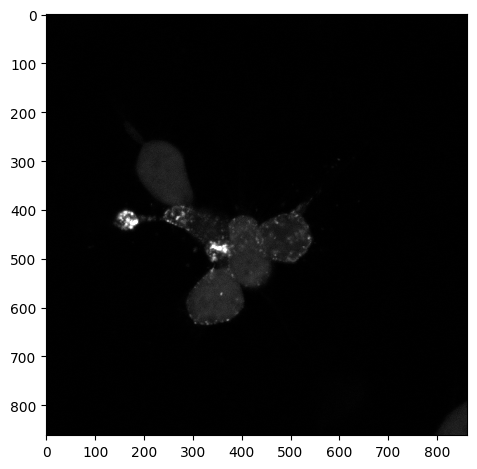

[0.07617188 0.43945312]


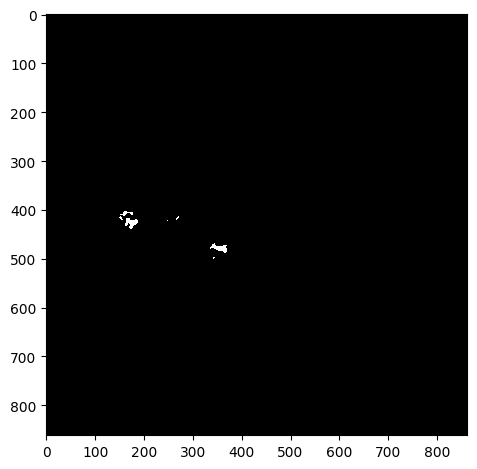

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_02.czi


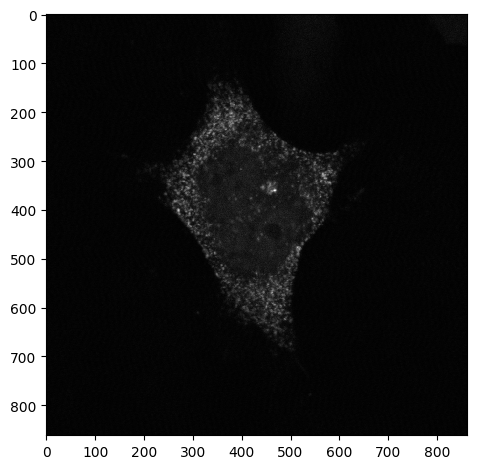

[0.06445312 0.18945312]


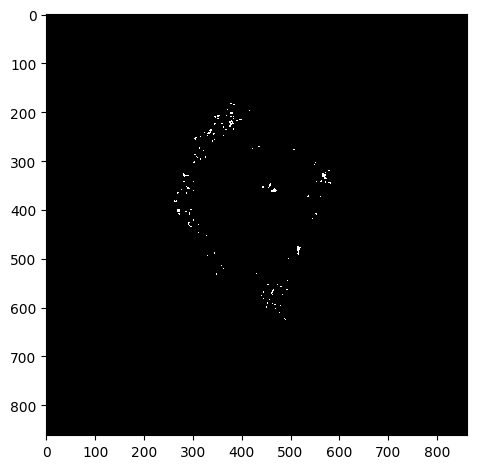

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_03.czi


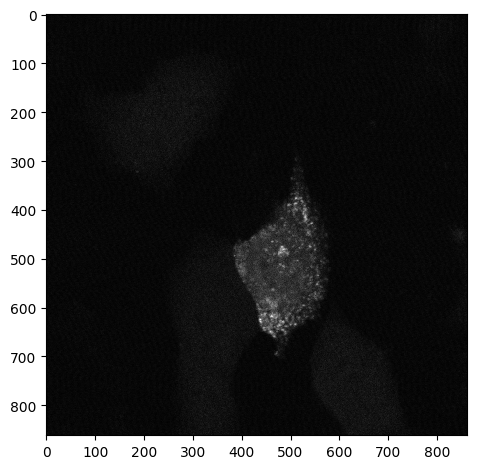

[0.05273438 0.15820312]


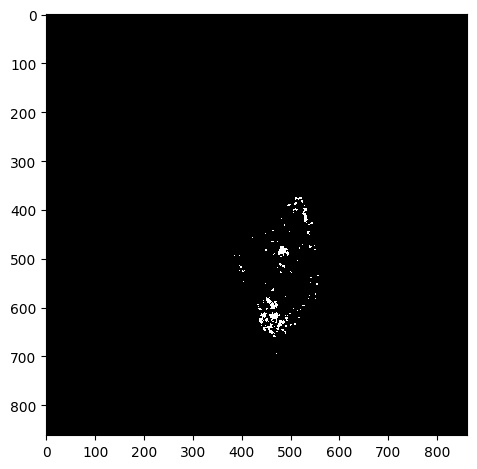

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_04.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


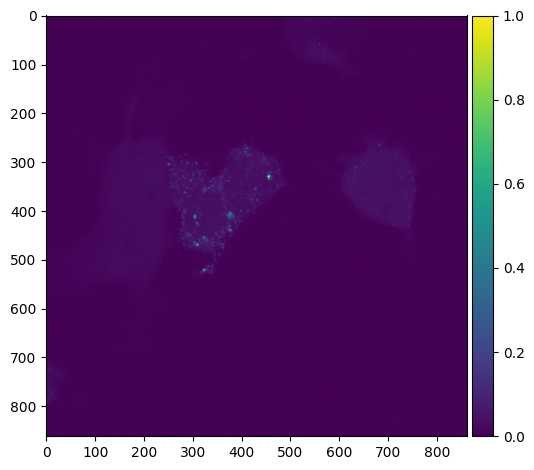

[0.02148438 0.15820312]


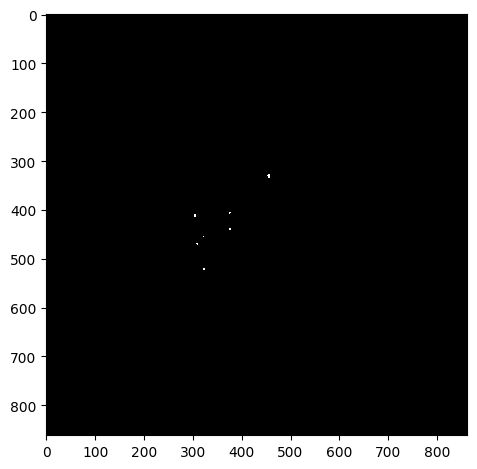

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_05.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


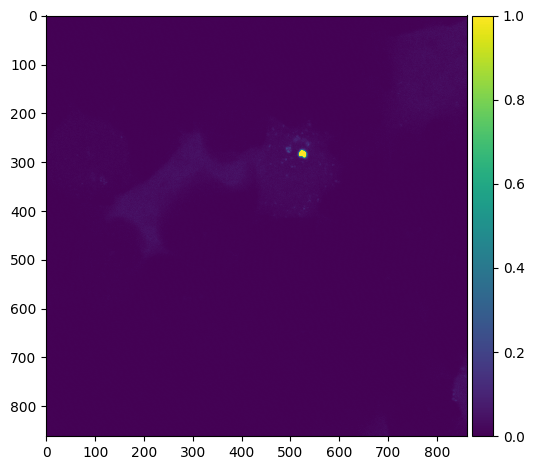

[0.01757812 0.45507812]


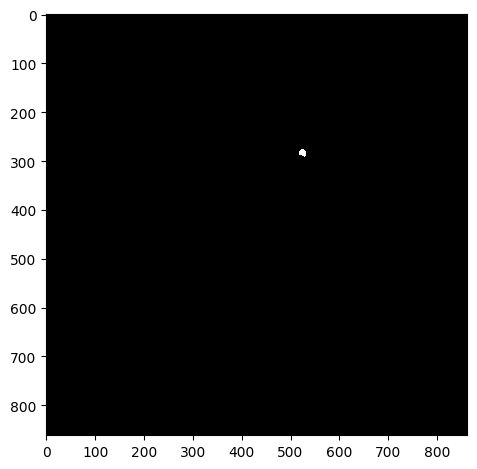

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_06.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


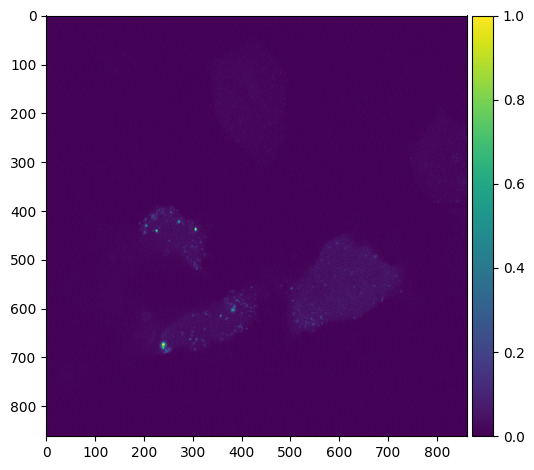

[0.02539062 0.25585938]


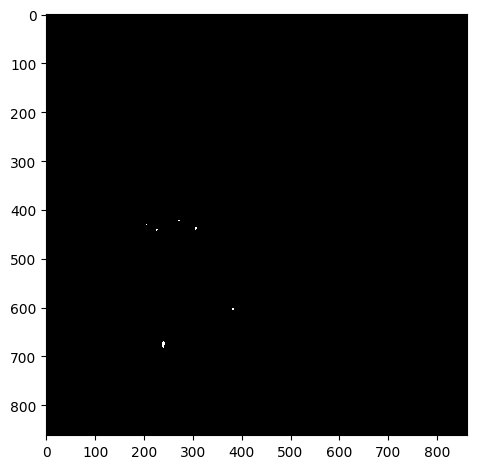

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_07.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


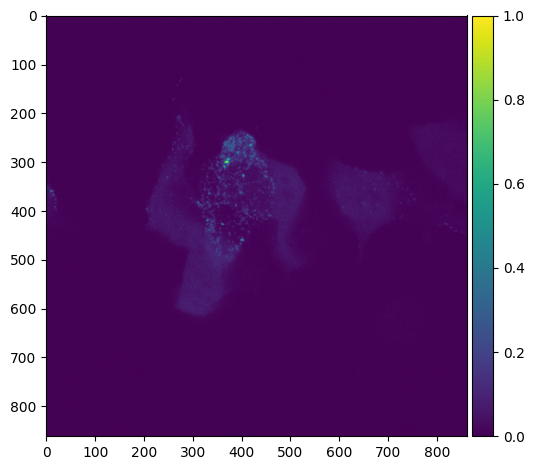

[0.02929688 0.11914062]


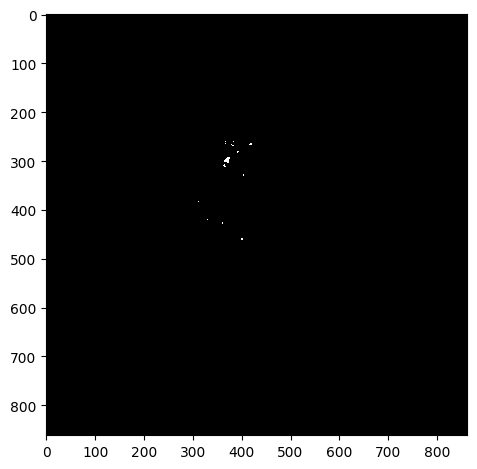

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_08.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


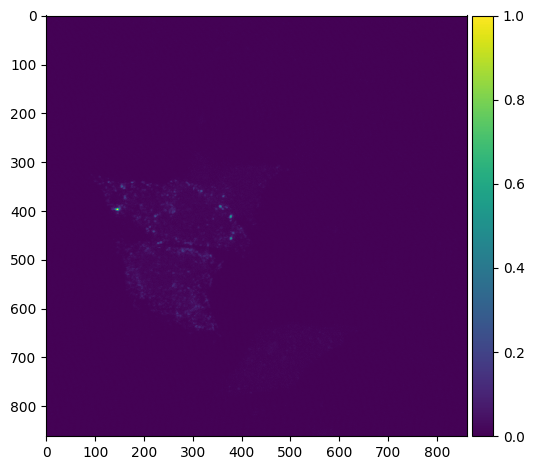

[0.02539062 0.23242188]


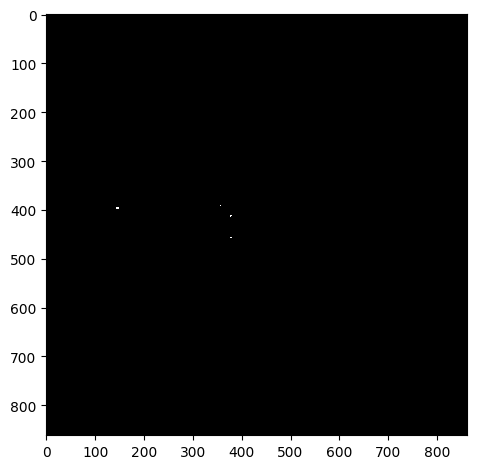

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_09.czi


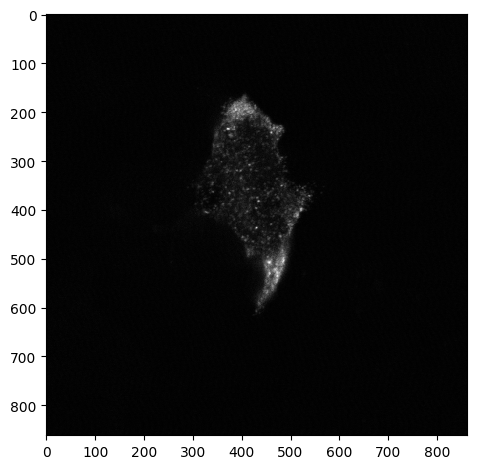

[0.06835938 0.25976562]


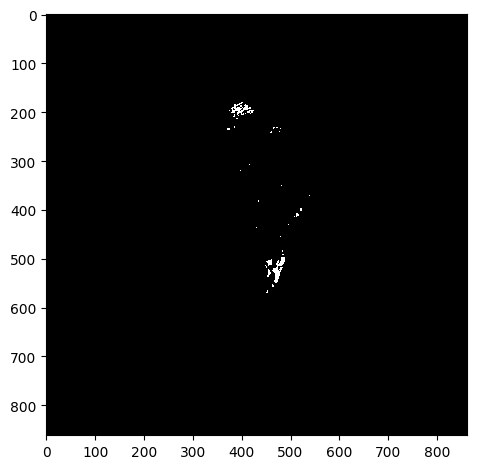

103124_PFF_HTRA1/new new settings\1K_PFF_HTRA1_Hoechst_20x_10.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


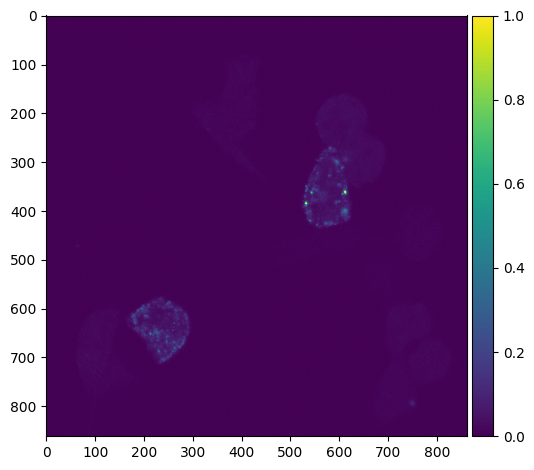

[0.03710938 0.14648438]


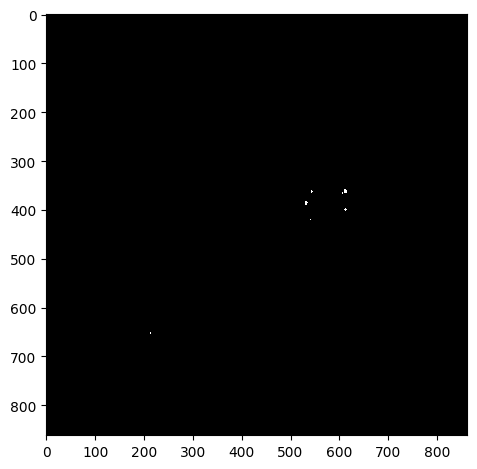

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_01.czi


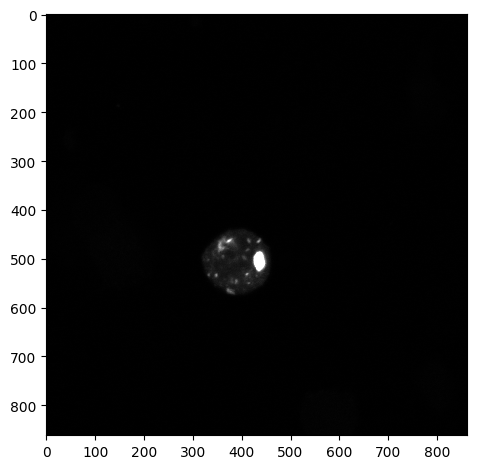

[0.07226562 0.52148438]


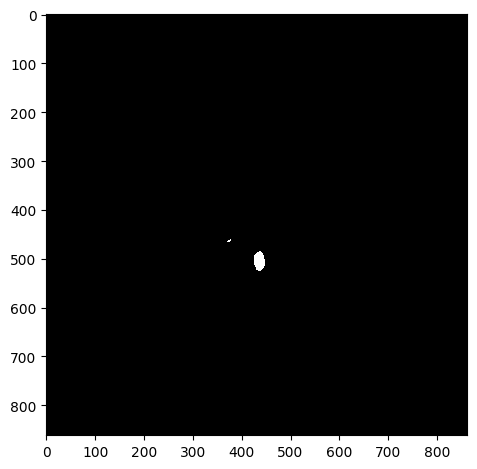

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_02.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


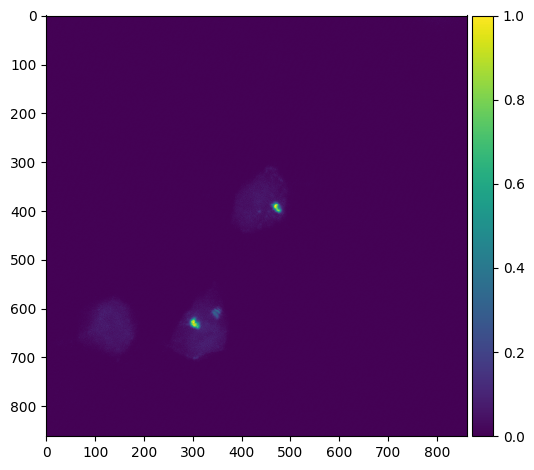

[0.02929688 0.34570312]


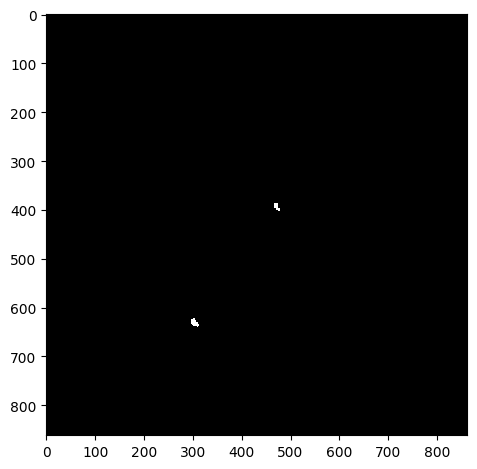

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_03.czi


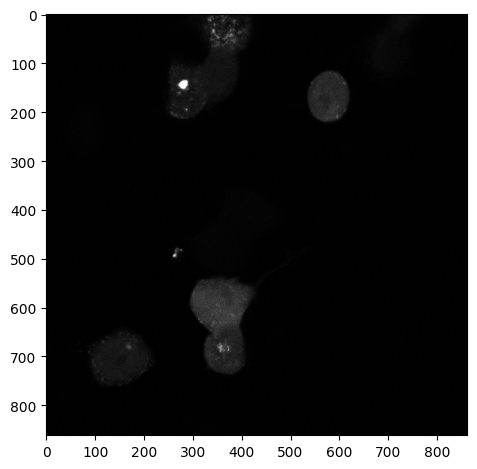

[0.07617188 0.47851562]


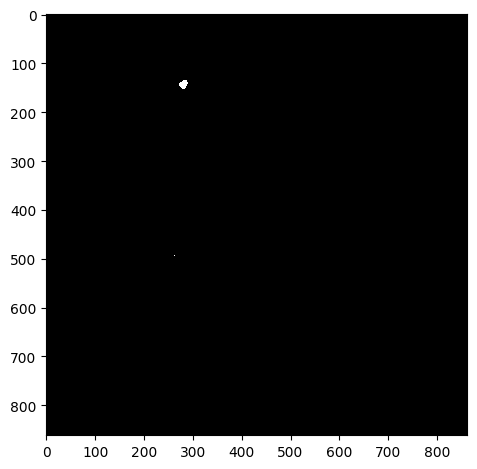

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_04.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


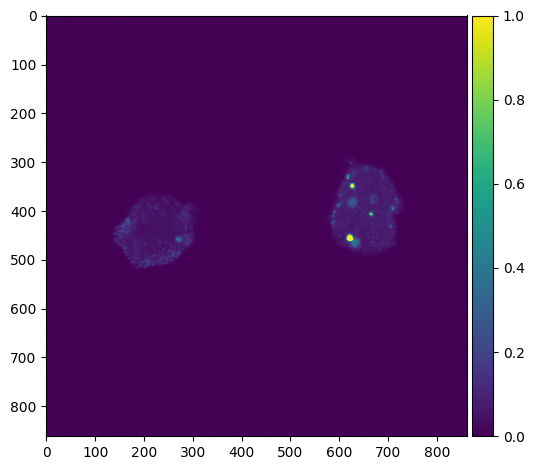

[0.04492188 0.43554688]


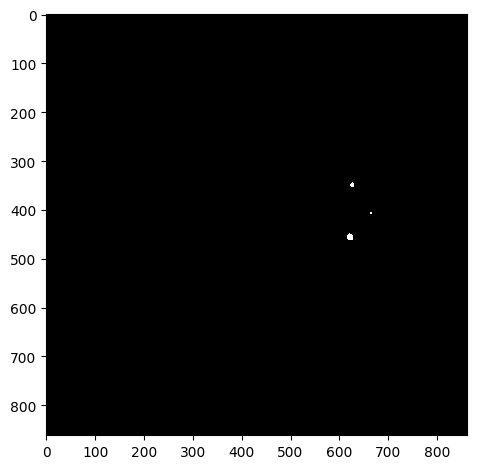

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_05.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


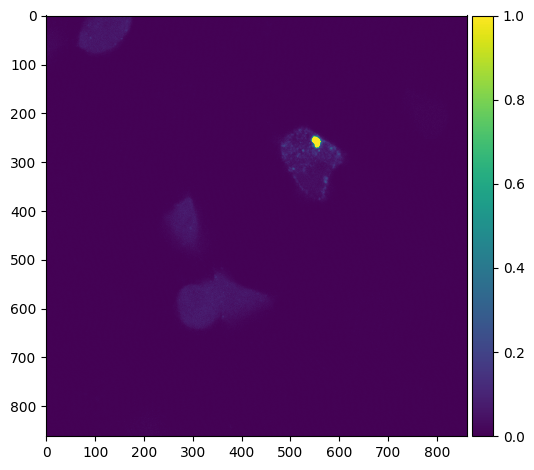

[0.03320312 0.50195312]


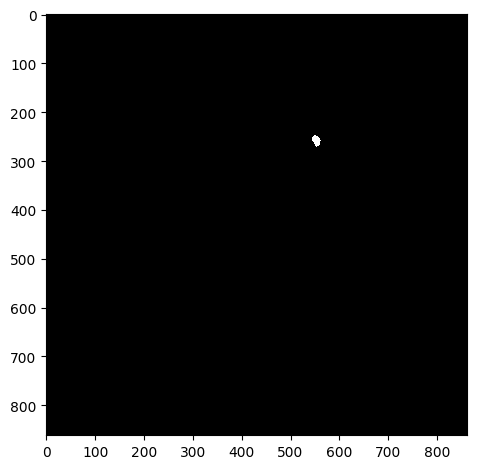

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_06.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


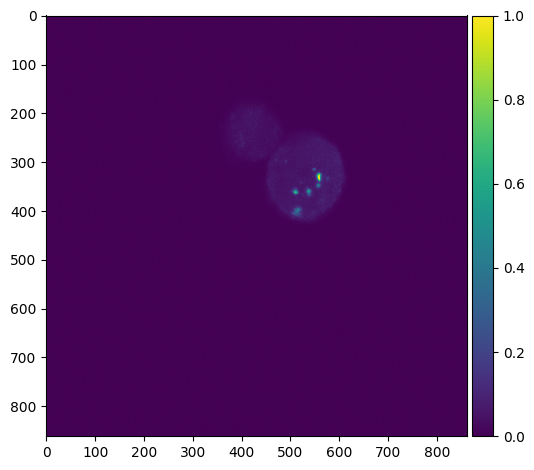

[0.02929688 0.24414062]


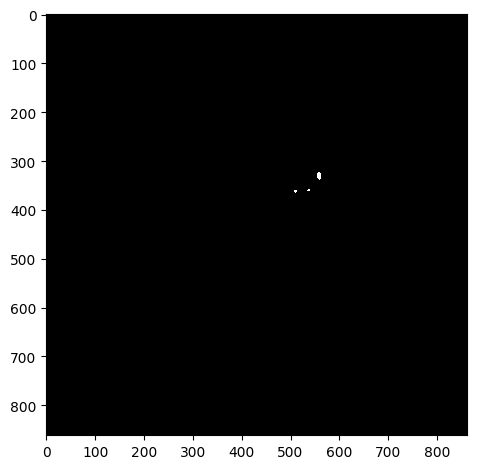

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_07.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


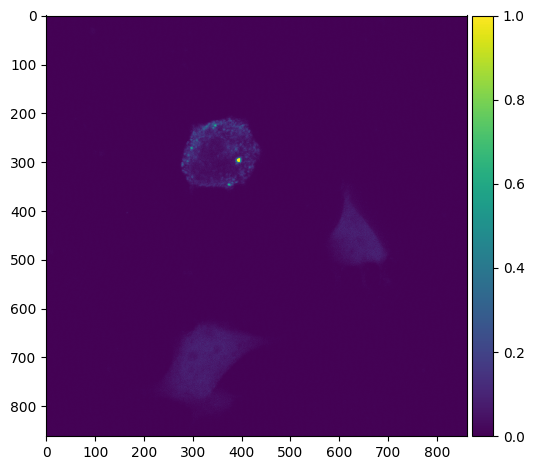

[0.04101562 0.33789062]


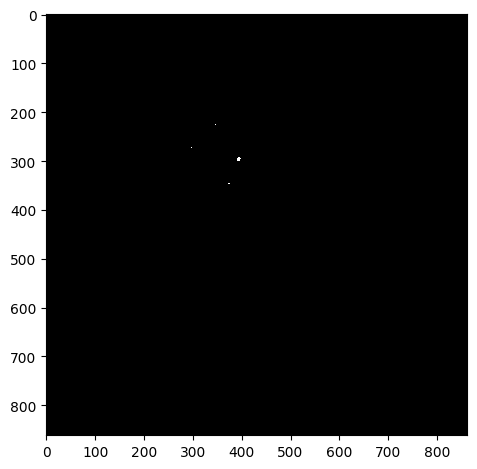

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_08.czi


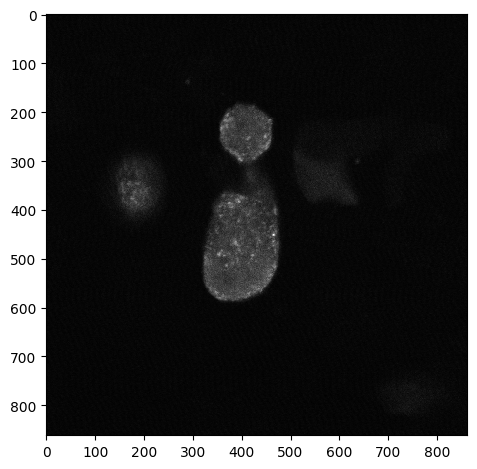

[0.08398438 0.21289062]


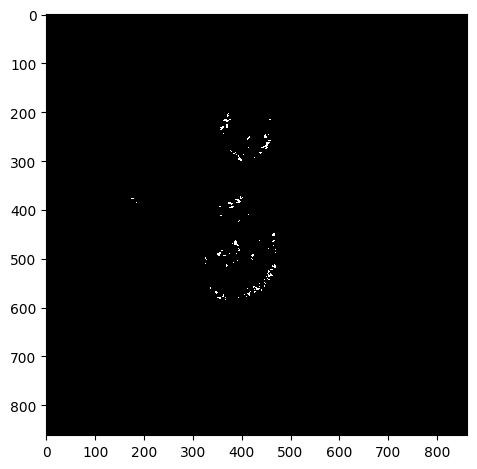

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_09.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


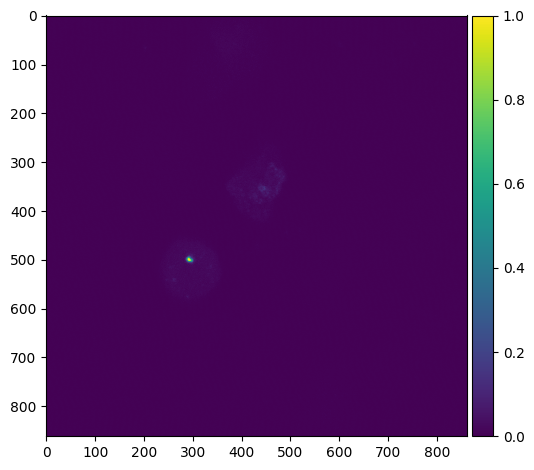

[0.01367188 0.33789062]


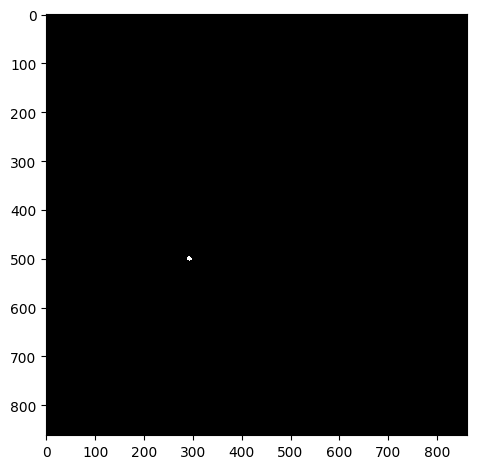

103124_PFF_HTRA1/new new settings\1K_PFF_noHTRA1_Hoechst_20x_10.czi


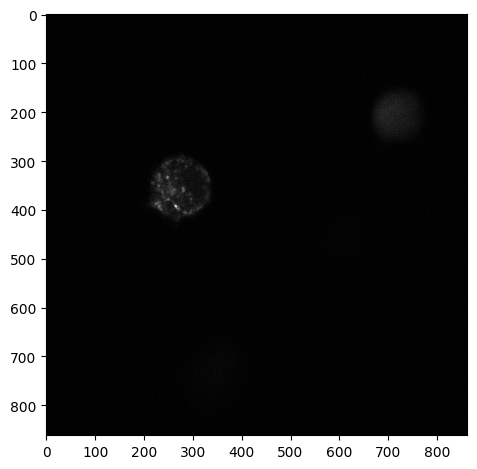

[0.05273438 0.16601562]


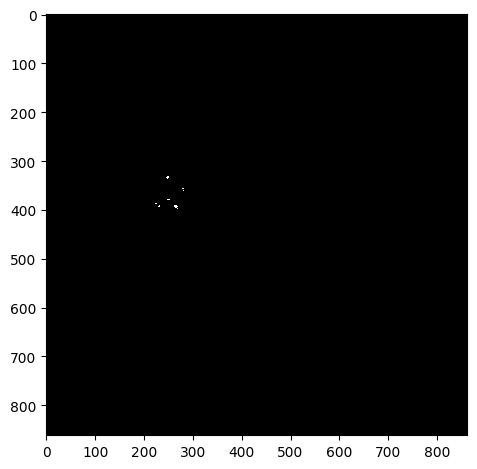

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_01.czi


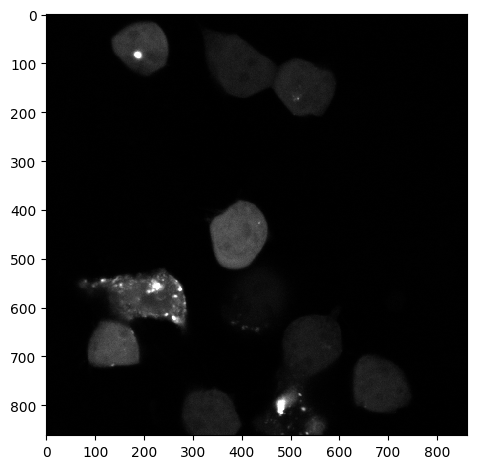

[0.05664062 0.20898438]


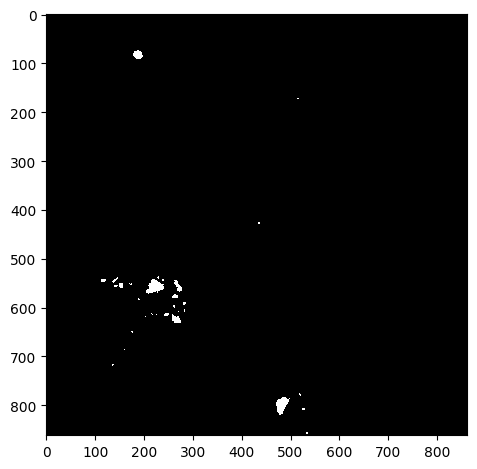

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_02.czi


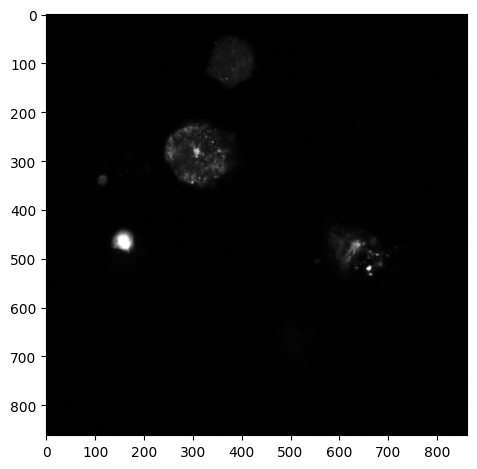

[0.07226562 0.45117188]


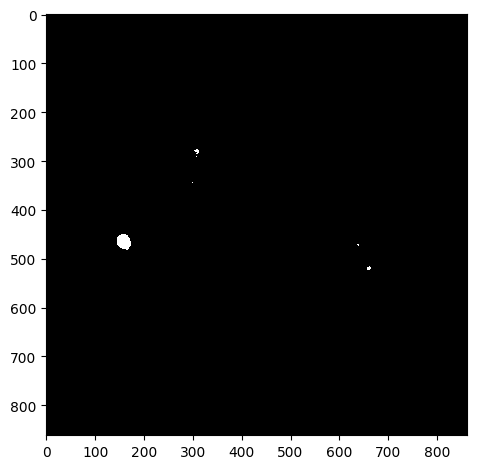

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_03.czi


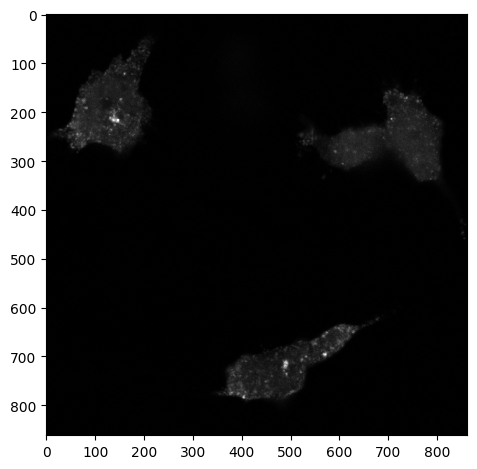

[0.06445312 0.20898438]


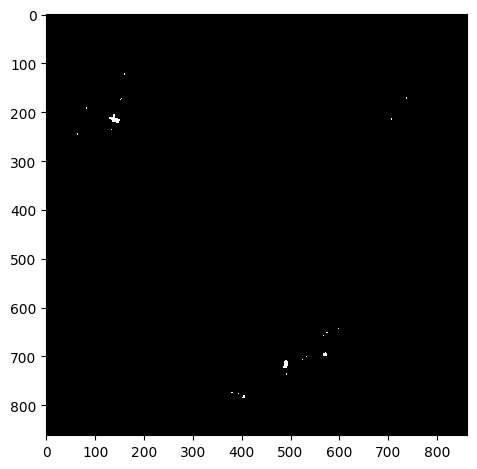

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_04.czi


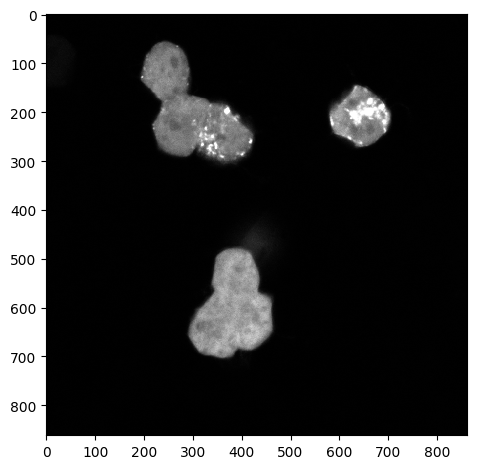

[0.23242188 0.56054688]


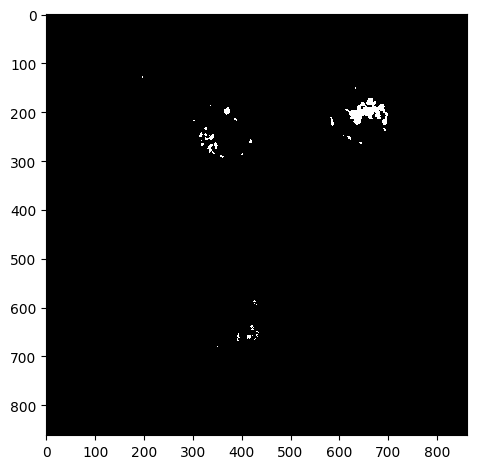

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_05.czi


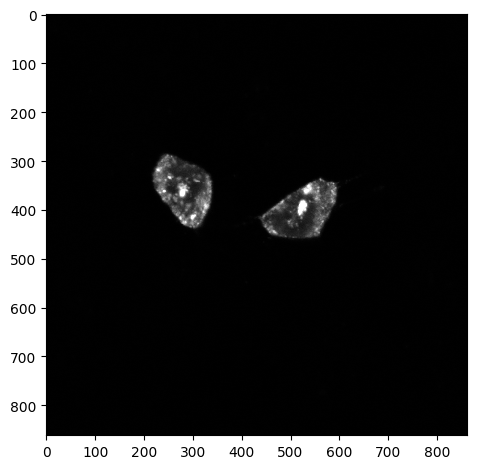

[0.13085938 0.44335938]


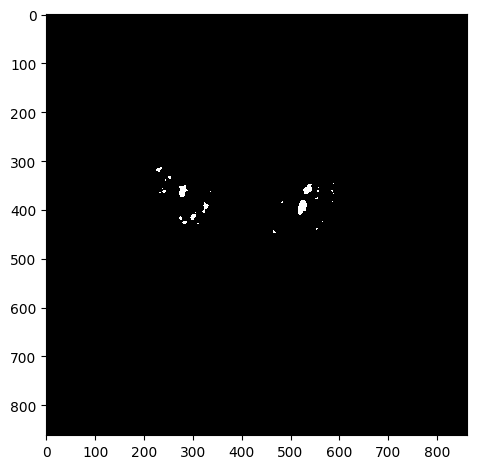

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_06.czi


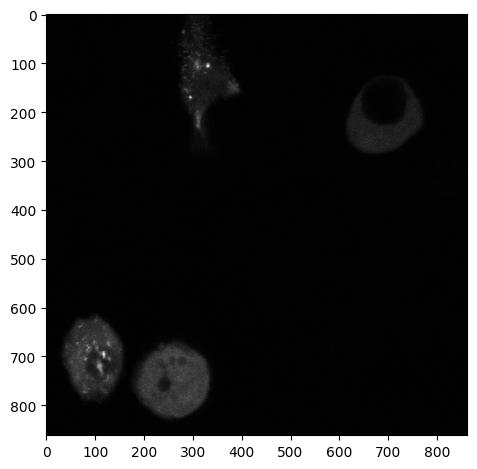

[0.05664062 0.16992188]


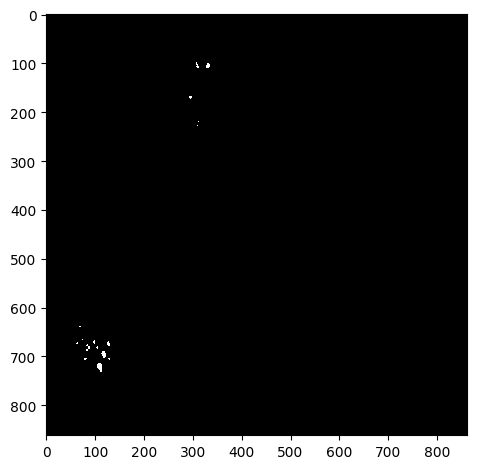

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_07.czi


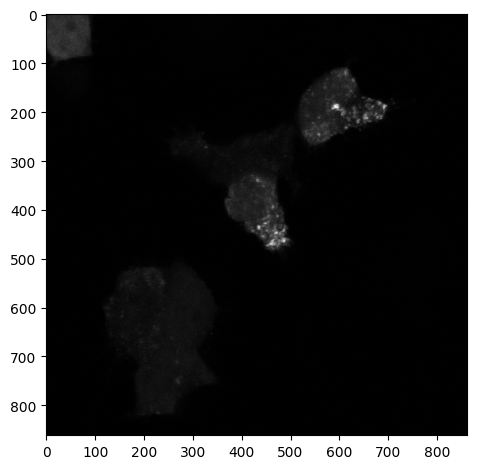

[0.03710938 0.13867188]


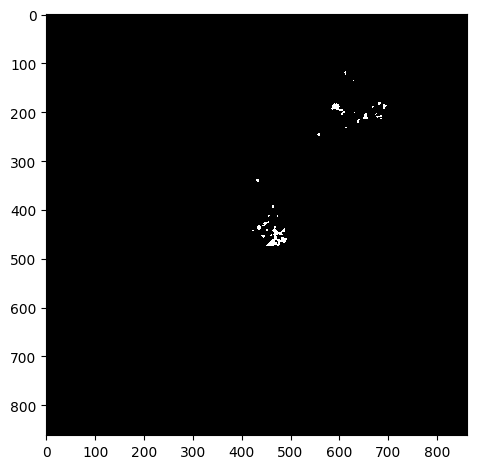

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_08.czi


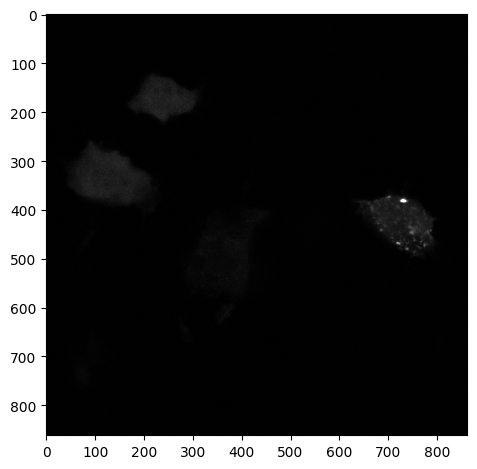

[0.05664062 0.44726562]


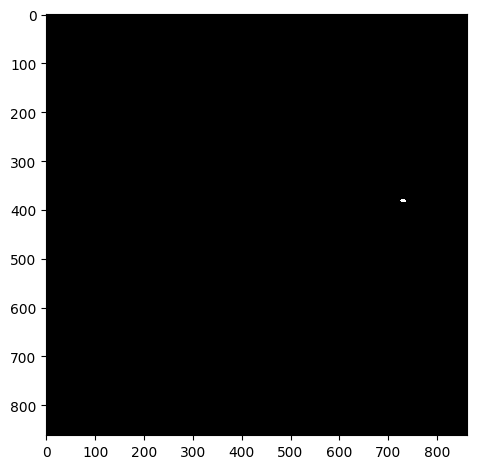

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_09.czi


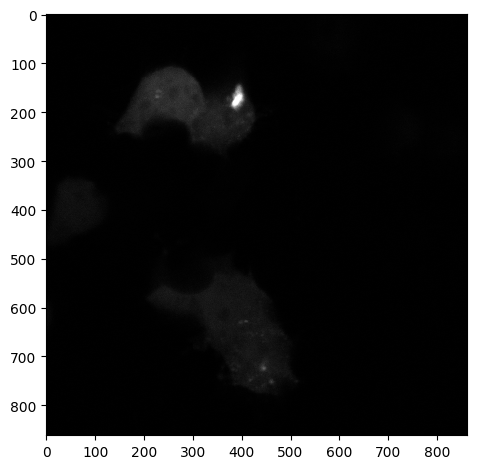

[0.05273438 0.42382812]


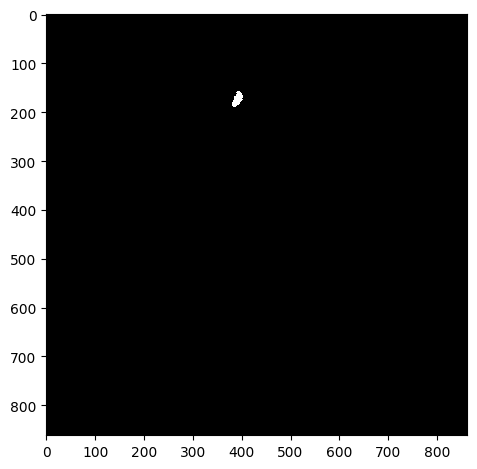

103124_PFF_HTRA1/new new settings\WT_PFF_HTRA1_Hoechst_20x_10.czi


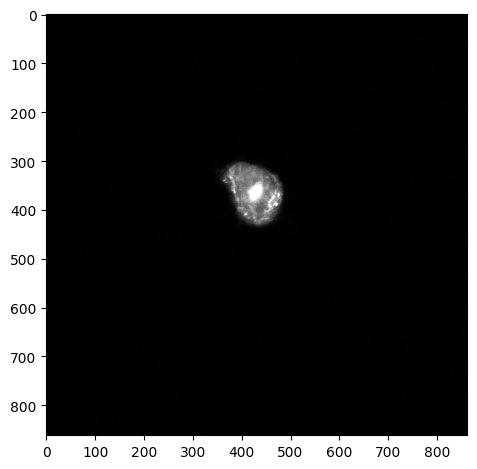

[0.22460938 0.64257812]


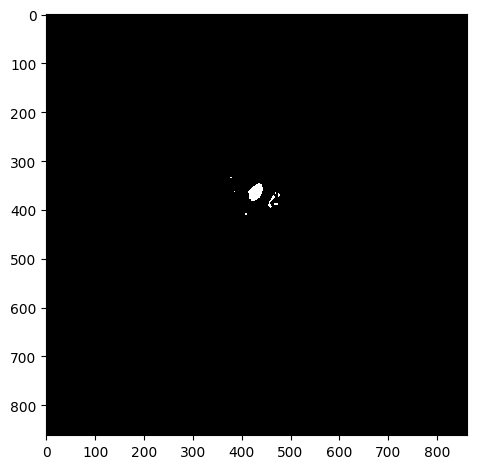

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_01.czi


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


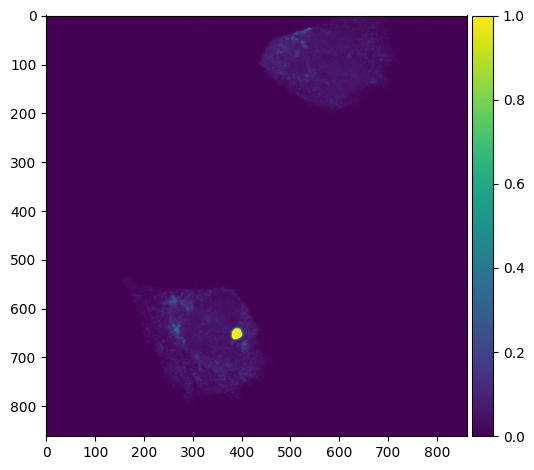

[0.03320312 0.50585938]


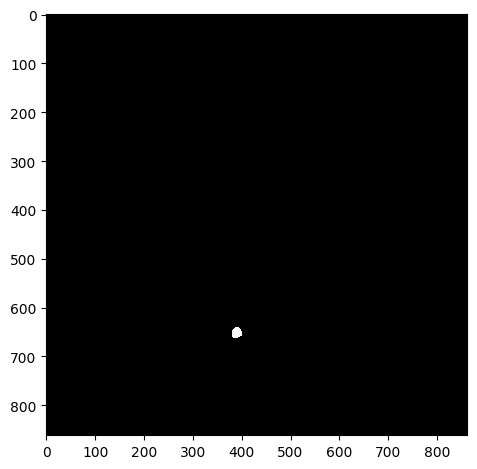

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_02.czi


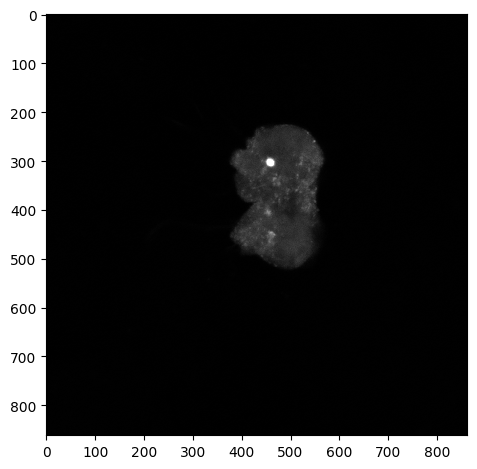

[0.09960938 0.52929688]


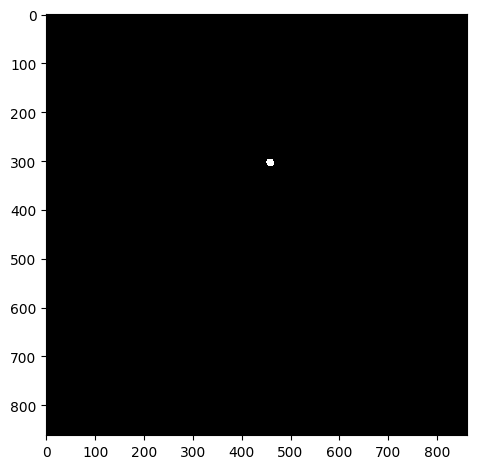

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_03.czi


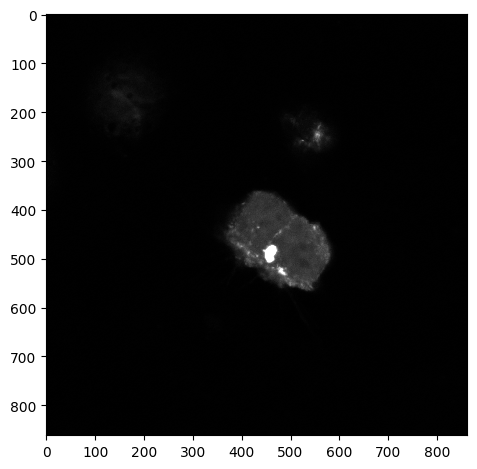

[0.11523438 0.56054688]


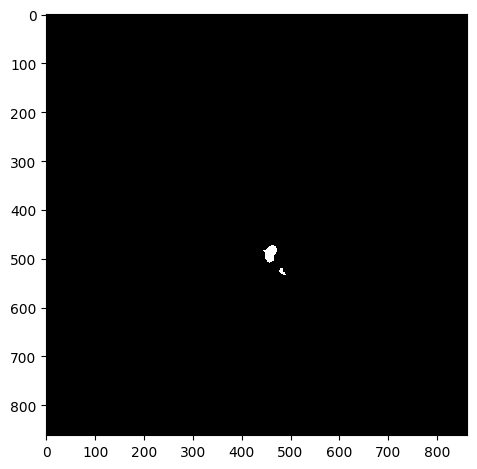

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_04.czi


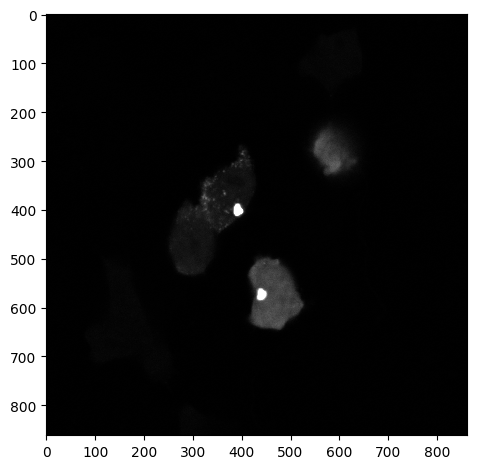

[0.12304688 0.58789062]


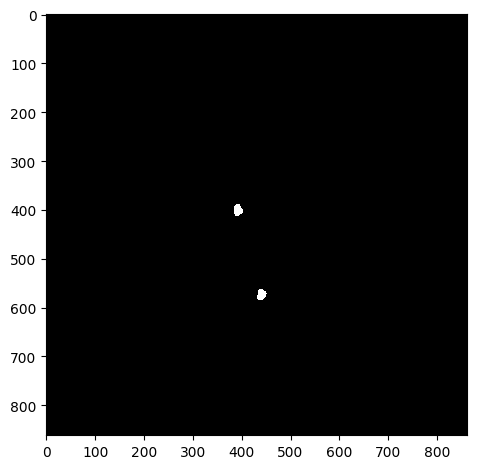

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_05.czi


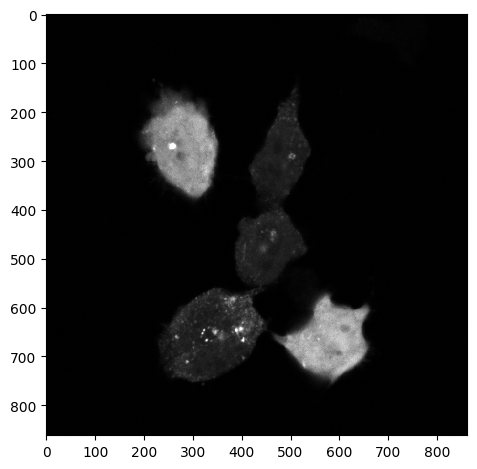

[0.07617188 0.37304688]


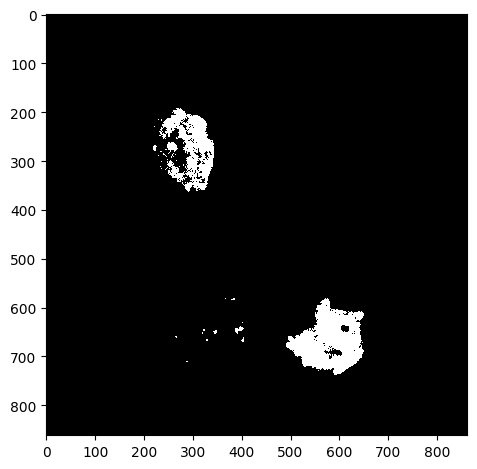

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_06.czi


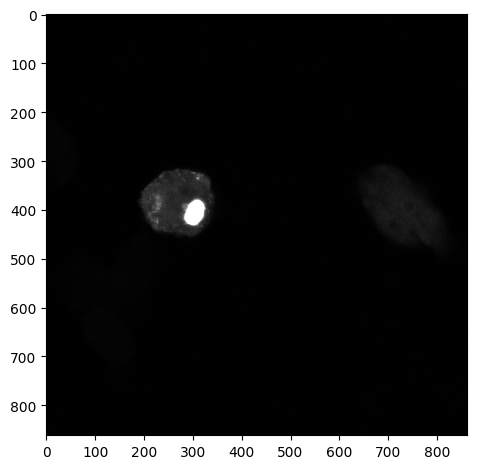

[0.07617188 0.55273438]


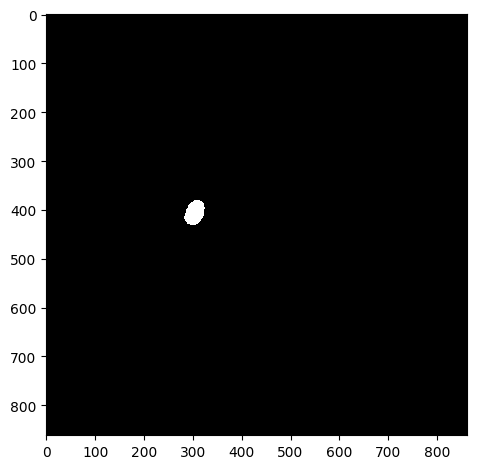

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_07.czi


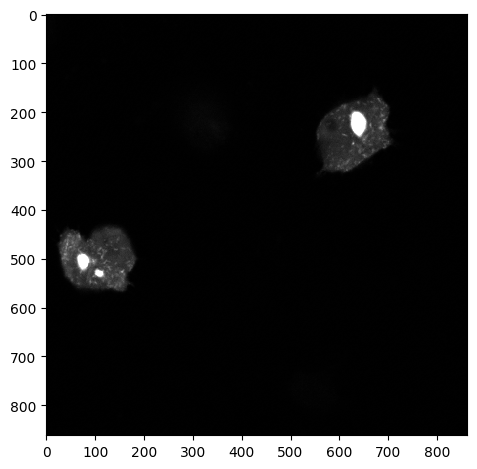

[0.11132812 0.58007812]


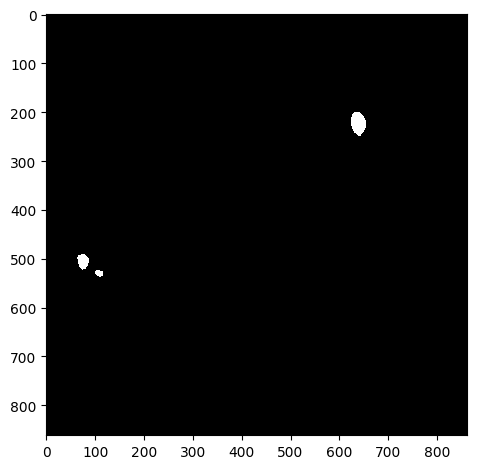

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_08.czi


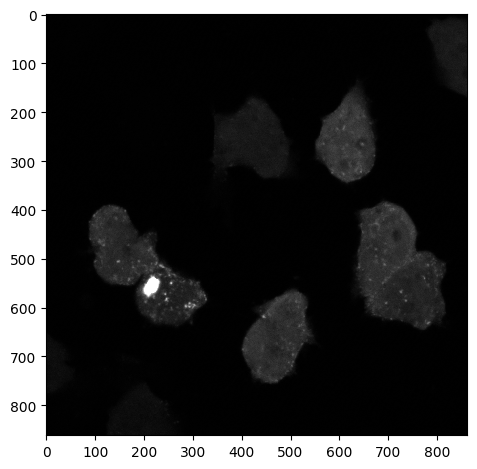

[0.08789062 0.53710938]


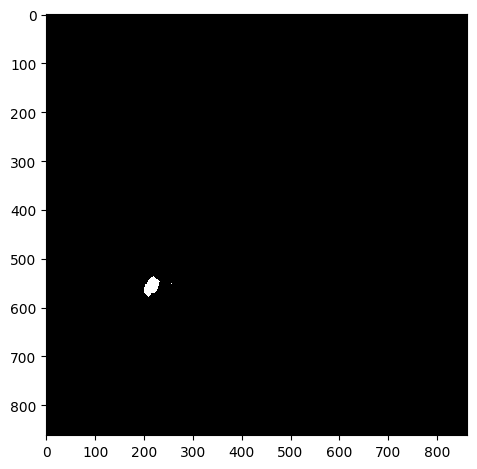

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_09.czi


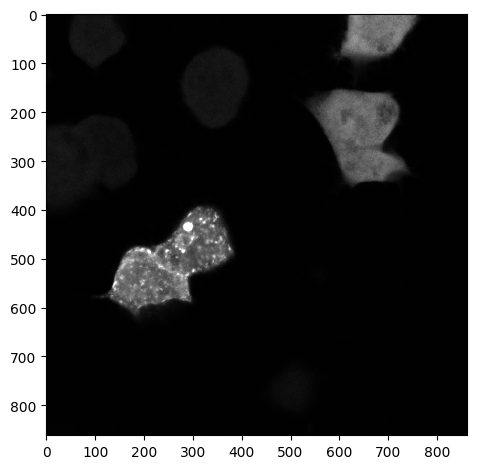

[0.17773438 0.43945312]


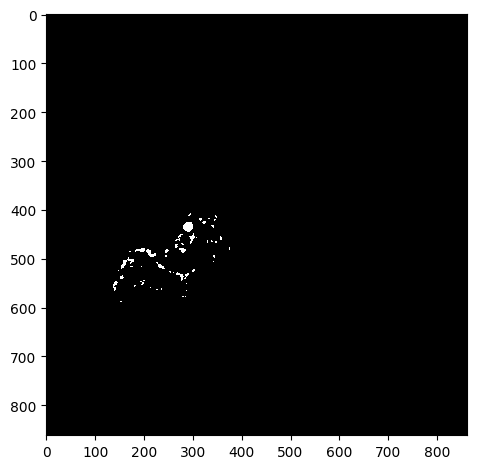

103124_PFF_HTRA1/new new settings\WT_PFF_noHTRA1_Hoechst_20x_10.czi


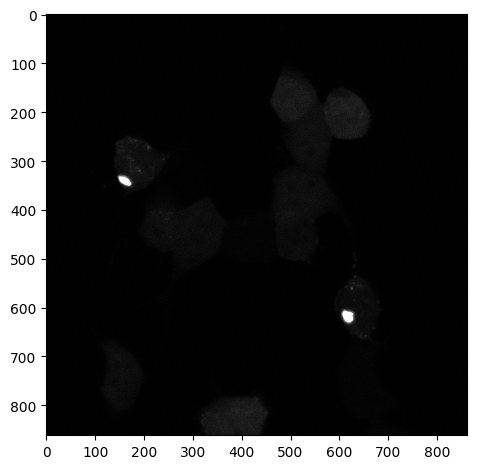

[0.03320312 0.48242188]


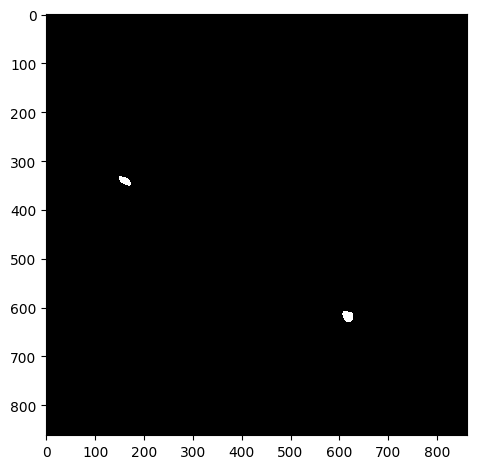

: 

In [ ]:
def main(image_folder):
    # Initialize lists to store results
    red_surface_areas = []
    number_of_nuclei_list = []
    total_inclusion_sizes = []
    mean_sizes_of_inclusions = []
    sizes_df_new = None
    overlap_areas = []

    images_to_analyze = extract_image_paths(image_folder)

    # Iterate over each image
    for path in images_to_analyze:
        print(path)
        dapi_channel, green_channel, red_channel = read_czi_image(path)
        
        # Process red channel for surface area
        binary_image_otsu, labeled_image_otsu = otsu_thresholding(red_channel)
        
       
        surface_area = calculate_surface_area(labeled_image_otsu, red_channel)
        if 'noHTRA' in path:
            red_surface_areas.append(0)
        else:
            red_surface_areas.append(surface_area)


        # Process DAPI channel for nuclei counting
        labeled_image_dapi = preprocess_dapi_channel(dapi_channel)

        n_nuclei = count_nuclei(labeled_image_dapi)
        number_of_nuclei_list.append(n_nuclei)

        # Process green channel for inclusion quantification
        confocal_img = preprocess_green_channel(green_channel)
        

        # fig, ax = try_all_threshold(confocal_img, figsize=(10, 8), verbose=False)
        # plt.show()
        
        binary_image_inclusions, labeled_image_inclusions = threshold_inclusions(confocal_img)
        
        
        inclusion_sizes = measure_inclusion_sizes(labeled_image_inclusions, confocal_img)
        mean_sizes_of_inclusions.append(np.mean(inclusion_sizes))
        total_inclusion_sizes.append(sum(inclusion_sizes))

        # Calculate overlap between red channel and inclusions
        if 'noHTRA' in path:
            overlap_areas.append(0)
        else:    
            overlap_area = measure_overlap_sizes(labeled_image_inclusions, binary_image_otsu)
            overlap_areas.append(overlap_area)

        # Add to DataFrame
        sizes_df_new = add_to_dataframe(sizes_df_new, inclusion_sizes, os.path.basename(path))

    # Calculate metrics and save results
    excel_2 = calculate_metrics(red_surface_areas, number_of_nuclei_list, mean_sizes_of_inclusions, overlap_areas, total_inclusion_sizes, sizes_df_new)
    excel_2.to_excel(f"Analysis_1_{image_folder[:6]}.xlsx")

if __name__ == "__main__":
    image_folder = '103124_PFF_HTRA1/new new settings' # threshold = 0.95
    
    main(image_folder)
